# Decision Tree Lab

In [1]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import arff
import pandas as pd
from scipy import stats
from IPython.core.display import display
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
import math

from matplotlib.pyplot import figure

import pprint
import pdb

In [2]:
pp = pprint.PrettyPrinter(indent=4)

In [3]:
def print_encodings(enc):
    encoding = enc.categories_
    encoding_feature = lambda x: dict(zip(x, range(len(x))))
    encoding_full = [encoding_feature(feature_elem) for feature_elem in encoding]
    pp.pprint(encoding_full)

## 1. (40%) Correctly implement the ID3 decision tree algorithm, including the ability to handle unknown attributes (You do not need to handle real valued attributes).  
### Code Requirements/Notes:
- Use standard information gain as your basic attribute evaluation metric.  (Note that normal ID3 would usually augment information gain with gain ratio or some other mechanism to penalize statistically insignificant attribute splits. Otherwise, even with approaches like pruning below, the SSE type of overfit could still hurt us.) 
- You are welcome to create other classes and/or functions in addition to the ones provided below. (e.g. If you build out a tree structure, you might create a node class).
- It is a good idea to use a simple data set (like the lenses data or the pizza homework), which you can check by hand, to test your algorithm to make sure that it is working correctly. 

In [4]:
class DTNode():
    def __init__(self, X_data, Y_data, depth=1, is_split_node=True,
                 split_feature_index=0, feature_attribute_index=0, parent=None):

        self.X_data = X_data
        self.Y_data = Y_data
        self.depth = depth
        self.is_split_node = is_split_node # Is this node a split node?

        self.split_feature_index = split_feature_index # The index of the input features that node will split on
        self.feature_attribute_index = feature_attribute_index

        self.parent = parent # Pointer back to parent node. For computing gain

        self.value = [] # The values of each output class represented in the node
        self.children = [] # The child nodes of the self node after deciding split

        self.pred_out_class = -1
            # print('\t'*self.depth, )

In [5]:
class DTClassifier(BaseEstimator,ClassifierMixin):

    def __init__(self,counts=None, max_depth=np.inf):
        """ Initialize class with chosen hyperparameters.
        Args:
        Optional Args (Args we think will make your life easier):
            counts: A list of Ints that tell you how many types of each feature there are
        Example:
            DT  = DTClassifier()
            or
            DT = DTClassifier(count = [2,3,2,2])
            Dataset = 
            [[0,1,0,0],
            [1,2,1,1],
            [0,1,1,0],
            [1,2,0,1],
            [0,0,1,1]]

        """
        self.counts = counts
        self.root = None
        self.n_output_classes = None
        self.split_information_gains = []
        self.max_depth = max_depth
        

    def fit(self, X, y):
        """ Fit the data; Make the Decision tree

        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
            y (array-like): A 1D numpy array with the training targets

        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)

        """
        self.root = DTNode(X, y)
        self.n_output_classes = len(np.unique(y))

        self._make_split(self.root)

        return self

    def predict(self, X):
        """ Predict all classes for a dataset X

        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets

        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """

        predictions = np.zeros(shape=(X.shape[0]))

        for i in range(X.shape[0]):
            instance = X[i, :]
            prediction = self._predict(self.root, instance)
            predictions[i] = prediction

        return predictions

    def _predict(self, node, instance):

        if not node.is_split_node:
            return node.pred_out_class

        split_feature_index = node.split_feature_index
        instance_attribute_val = int(instance[split_feature_index])
        next_node = node.children[instance_attribute_val]
        return self._predict(next_node, instance)


    def score(self, X, y):
        """ Return accuracy(Classification Acc) of model on a given dataset. Must implement own score function.

        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 1D numpy array of the targets 
        """

        predictions = self.predict(X)

        score = np.mean(np.where(y == predictions, 1, 0))

        return score

    def print_tree(self, feature_names, enc):
        self.print_tree_helper(self.root, feature_names, enc)

    def print_tree_helper(self, node, feature_names, enc):
        if node.is_split_node:

            for i in range(len(node.children)):
                child_node = node.children[i]
                print('\t'*(node.depth-1),
                      feature_names[node.split_feature_index], ' = ',
                      enc.categories_[node.split_feature_index][i], ":")
                self.print_tree_helper(child_node, feature_names, enc)

        else:
            print('\t'*(node.depth-1), "prediction: ", enc.categories_[-1][node.pred_out_class])

    def _info(self, node):
        X = node.X_data
        Y = node.Y_data

        node_info = 0
        for C in range(self.n_output_classes): # For each output class
            filter = np.where(Y == C, 1, 0)
            n_instances = np.sum(filter)

            if len(Y) == 0:
                return 0
                
            p_i = np.sum(filter) / len(Y)

            if len(Y) == 0:
                return 0

            if p_i != 0:
                node_info += p_i * np.log2(p_i)

        return -node_info

    def _make_split(self, node):
        # Base case - When there is only one class in node
        if (len(np.unique(node.Y_data)) == 1 or \
                node.depth == self.max_depth):
            node.is_split_node = False
            node.pred_out_class = int(stats.mode(node.Y_data)[0])
            return

        # Get the best split children and feature split index
        node.children, node.split_feature_index = self._get_best_split_children(node)

        if None in node.children:
            node.children = []
            node.is_split_node = False
            node.pred_out_class = int(stats.mode(node.Y_data)[0])
            return

        for child_node in node.children:
            self._make_split(child_node)

    def _get_best_split_children(self, node):

        # For each input feature
        X = node.X_data
        Y = node.Y_data
        len_S = len(Y)

        max_gain = 0
        best_feature_split_ind = 0
        best_split_children = None

        for feature_ind in range(X.shape[1]):

            # Skip if the attribute only has one unique value
            if (len(np.unique(X[:, feature_ind])) == 1):
                continue

            # Calculate the gain of splitting on that feature
            contender_child_nodes = []
            info_A = 0

            for attribute_val in range(self.counts[feature_ind]): # TODO make sure this calculates correctly.

                mask = np.where(X[:, feature_ind] == attribute_val)

                X_new = X[mask]
                Y_new = Y[mask]

                if len(Y_new) == 0:
                    contender_child_nodes.append(None)
                    continue

                node_new = DTNode(X_new, Y_new, depth=node.depth + 1,
                                  is_split_node=True, split_feature_index=feature_ind,
                                  feature_attribute_index=attribute_val,
                                  parent=node)
                contender_child_nodes.append(node_new)

                info_S_j = self._info(node_new)
                if info_S_j == None:
                    info_S_j = 0
                len_S_j = len(Y_new)
                
                info_A += (len_S_j / len_S) * info_S_j

            gain = self._info(node) - info_A

            if gain > max_gain:
                max_gain = gain
                best_feature_split_ind = feature_ind
                best_split_children = contender_child_nodes
            
        self.split_information_gains.append(max_gain)
        return best_split_children, best_feature_split_ind

## 1.1 Debug

Debug your model by training on the lenses dataset: [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/lenses.arff)

Test your model on the lenses test set: [Debug Test Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/lenses_test.arff)

Parameters:
(optional) counts = [3,2,2,2] (You should compute this when you read in the data, before fitting)

---

Expected Results: Accuracy = [0.33]

Predictions should match this file: [Lenses Predictions](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/pred_lenses.csv)

*NOTE: The [Lenses Prediction](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/pred_lenses.csv) uses the following encoding: soft=2, hard=0, none=1. If your encoding is different, then your output will be different, but not necessarily incorrect.*

Split Information Gains (These do not need to be in this exact order):

[0.5487949406953987, 0.7704260414863775, 0.3166890883150208, 1.0, 0.4591479170272447, 0.9182958340544894]

<!-- You should be able to get about 68% (61%-82%) predictive accuracy on the lenses data -->

Here's what your decision tree splits should look like, and the corresponding child node predictions:

Decision Tree:
<pre>
tear_prod_rate = normal:
    astigmatism = no:
        age = pre_presbyopic:
            prediction: soft
        age = presbyopic:
            spectacle_prescrip = hypermetrope:
                prediction: soft
            spectacle_prescrip = myope:
                prediction: none
        age = young:
            prediction: soft
    astigmatism = yes:
        spectacle_prescrip = hypermetrope:
            age = pre_presbyopic:
                prediction: none
            age = presbyopic:
                prediction: none
            age = young:
                prediction: hard
        spectacle_prescrip = myope:
            prediction: hard
tear_prod_rate = reduced:
    prediction: none
</pre>

In [6]:
# Load debug training and testing data 
debug_train_data = arff.loadarff('datasets/lenses.arff')
debug_trainDF = pd.DataFrame(debug_train_data[0])
for column in debug_trainDF.columns:
    debug_trainDF[column] = debug_trainDF[column] \
                         .astype(str).str \
                         .split("\'", expand=True) \
                         .iloc[:,1]

debug_test_data = arff.loadarff('datasets/lenses_test.arff')
debug_testDF = pd.DataFrame(debug_test_data[0])
for column in debug_testDF.columns:
    debug_testDF[column] = debug_testDF[column] \
                         .astype(str).str \
                         .split("\'", expand=True) \
                         .iloc[:,1]

# display(debug_trainDF.head(2))
# display(debug_testDF.head(2))

# Encode data
debug_enc = OrdinalEncoder()
debug_enc.fit(debug_trainDF)
debug_train = debug_enc.transform(debug_trainDF)
debug_test = debug_enc.transform(debug_testDF)

# pp.pprint(debug_enc.categories_)
# print_encodings(debug_enc)

# Save metadata
counts = debug_trainDF.nunique().to_numpy()[:-1]
features = debug_trainDF.columns

# X and Y splits
X_train = debug_train[:, :-1]
X_test = debug_test[:, :-1]
Y_train = debug_train[:, -1]
Y_test = debug_test[:, -1]

# Train Decision Tree
dtc = DTClassifier(counts=counts)
dtc.fit(X_train, Y_train)

# Print the decision tree
print('DECISION TREE')
dtc.print_tree(features, debug_enc)
print()

# Predict and compute model accuracy
print('TEST SCORE')
print(dtc.score(X_test, Y_test))

# Print the information gain of every split you make.
print('SPLIT INFORMATION GAINS')
print(dtc.split_information_gains)
print()

DECISION TREE
 tear_prod_rate  =  normal :
	 astigmatism  =  no :
		 age  =  pre_presbyopic :
			 prediction:  soft
		 age  =  presbyopic :
			 spectacle_prescrip  =  hypermetrope :
				 prediction:  soft
			 spectacle_prescrip  =  myope :
				 prediction:  none
		 age  =  young :
			 prediction:  soft
	 astigmatism  =  yes :
		 spectacle_prescrip  =  hypermetrope :
			 age  =  pre_presbyopic :
				 prediction:  none
			 age  =  presbyopic :
				 prediction:  none
			 age  =  young :
				 prediction:  hard
		 spectacle_prescrip  =  myope :
			 prediction:  hard
 tear_prod_rate  =  reduced :
	 prediction:  none

TEST SCORE
0.3333333333333333
SPLIT INFORMATION GAINS
[0.5487949406953985, 0.7704260414863778, 0.3166890883150208, 1.0, 0.4591479170272448, 0.9182958340544896]



In [7]:
# TENNIS EXAMPLE
# Load debug training and testing data
example_train_data = arff.loadarff('datasets/examples/tennis.arff')
example_trainDF = pd.DataFrame(example_train_data[0])
for column in example_trainDF.columns:
    example_trainDF[column] = example_trainDF[column] \
                                    .astype(str).str \
                                    .split("\'", expand=True) \
                                    .iloc[:,1]

# Encode data
example_enc = OrdinalEncoder()
example_enc.fit(example_trainDF)
example_train = example_enc.transform(example_trainDF)
example_test = example_enc.transform(example_trainDF)

# pp.pprint(example_enc.categories_)
# print_encodings(example_enc)

# Save metadata
counts = example_trainDF.nunique().to_numpy()[:-1]
features = example_trainDF.columns

# X and Y splits
X_train_example = example_train[:, :-1]
Y_train_example = example_train[:, -1]

# Train Decision Tree
dtc = DTClassifier(counts=counts)
dtc.fit(X_train_example, Y_train_example)
dtc.print_tree(features, example_enc)

 outlook  =  overcast :
	 prediction:  yes
 outlook  =  rain :
	 wind  =  strong :
		 prediction:  no
	 wind  =  weak :
		 prediction:  yes
 outlook  =  sunny :
	 humidity  =  high :
		 prediction:  no
	 humidity  =  normal :
		 prediction:  yes


In [8]:
# Optional/Additional Debugging Dataset - Pizza Homework
# pizza_dataset = np.array([[1,2,0],[0,0,0],[0,1,1],[1,1,1],[1,0,0],[1,0,1],[0,2,1],[1,0,0],[0,2,0]])
# pizza_labels = np.array([2,0,1,2,1,2,1,1,0])

## 1.2 Evaluation

We will evaluate your model based on its performance on the zoo dataset. 

Train your model using this dataset: [Evaluation Train Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/zoo.arff)

Test your model on this dataset: [Evaluation Test Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/zoo_test.arff)

Parameters:
(optional) counts = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2] (You should compute this when you read in the data, before fitting)

---
Print out your accuracy on the evaluation test dataset.

Print out the information gain of every split you make.

In [9]:
# Load evaluation training data
eval_train_data = arff.loadarff('datasets/zoo.arff')
eval_trainDF = pd.DataFrame(eval_train_data[0])
for column in eval_trainDF.columns:
    eval_trainDF[column] = eval_trainDF[column] \
                         .astype(str).str \
                         .split("\'", expand=True) \
                         .iloc[:,1]

display(eval_trainDF.head())

# Load evaluation test data
eval_test_data = arff.loadarff('datasets/zoo.arff')
eval_testDF = pd.DataFrame(eval_test_data[0])
for column in eval_testDF.columns:
    eval_testDF[column] = eval_testDF[column] \
                         .astype(str).str \
                         .split("\'", expand=True) \
                         .iloc[:,1]

# display(debug_trainDF.head(2))
# display(debug_testDF.head(2))

# Encode data
eval_enc = OrdinalEncoder()
eval_enc.fit(eval_trainDF)
eval_train = eval_enc.transform(eval_trainDF)
eval_test = eval_enc.transform(eval_testDF)

# Save metadata
eval_counts = eval_trainDF.nunique().to_numpy()[:-1]
eval_features = eval_trainDF.columns

# X and Y splits
X_eval_train = eval_train[:, :-1]
X_eval_test = eval_test[:, :-1]
Y_eval_train = eval_train[:, -1]
Y_eval_test = eval_test[:, -1]

# Train Decision Tree
dtc = DTClassifier(counts=eval_counts)
dtc.fit(X_eval_train, Y_eval_train)

# Print the decision tree
print('DECISION TREE')
dtc.print_tree(eval_features, eval_enc)
print()

# Predict and compute model accuracy
print('TEST SCORE')
print(dtc.score(X_eval_test, Y_eval_test))

# Print out the information gain for every split you make
print('SPLIT INFORMATION GAINS')
print(dtc.split_information_gains)
print()

,hair,feathers,eggs,milk,airborne,predator,aquatic,toothed,backbone,breathes,venomous,fins,legs,tails,domestic,catsize,type
0,T,F,F,T,F,F,T,T,T,T,F,F,4,F,F,T,cT
1,T,F,F,T,F,F,F,T,T,T,F,F,4,T,F,T,cT
2,F,F,T,F,F,T,T,T,T,F,F,T,0,T,F,F,c4
3,T,F,F,T,F,F,T,T,T,T,F,F,4,F,F,T,cT
4,T,F,F,T,F,F,T,T,T,T,F,F,4,T,F,T,cT


DECISION TREE
 legs  =  0 :
	 fins  =  F :
		 toothed  =  F :
			 prediction:  c7
		 toothed  =  T :
			 prediction:  c3
	 fins  =  T :
		 eggs  =  F :
			 prediction:  cT
		 eggs  =  T :
			 prediction:  c4
 legs  =  2 :
	 hair  =  F :
		 prediction:  c2
	 hair  =  T :
		 prediction:  cT
 legs  =  4 :
	 hair  =  F :
		 predator  =  F :
			 prediction:  c3
		 predator  =  T :
			 toothed  =  F :
				 prediction:  c7
			 toothed  =  T :
				 prediction:  c5
	 hair  =  T :
		 prediction:  cT
 legs  =  5 :
	 prediction:  c7
 legs  =  6 :
	 predator  =  F :
		 prediction:  c6
	 predator  =  T :
		 prediction:  c7
 legs  =  8 :
	 prediction:  c7

TEST SCORE
1.0
SPLIT INFORMATION GAINS
[1.3630469031539394, 0.8865408928220899, 0.9852281360342515, 0.6962122601251458, 0.8256265261578954, 0.6892019851173654, 0.8631205685666308, 0.7219280948873623, 0.7219280948873623]



## 2. (20%) You will use your ID3 algorithm to induce decision trees for the cars dataset and the voting dataset.  Do not use a stopping criteria, but induce the tree as far as it can go (until classes are pure or there are no more data or attributes to split on).  
- Implement and use 10-fold Cross Validation (CV) on each data set to predict how well the models will do on novel data.  
- For each dataset, report the training and test classification accuracy for each fold and the average test accuracy. 
- As a rough sanity check, typical decision tree accuracies for these data sets are: Cars: .90-.95, Vote: .92-.95.

## 2.1 Implement 10-fold Cross Validation

In [10]:
# Write a function that implements 10-fold cross validation
def ten_fold_cv(X, Y, counts, max_depth=np.inf):
    sum = 0
    len_test_fold = X.shape[0] // 10

    for i in range(10):

        test_fold_start_ind = i * len_test_fold
        test_fold_end_ind = test_fold_start_ind + len_test_fold
        indices = np.array([test_fold_start_ind, test_fold_end_ind])

        X_arrays = np.split(X, indices, axis=0)
        Y_arrays = np.split(Y, indices, axis=0)
        X_train = np.append(X_arrays[0], X_arrays[2], axis=0)
        Y_train = np.append(Y_arrays[0], Y_arrays[2], axis=0)
        X_test = X_arrays[1]
        Y_test = Y_arrays[1]

        dtc = DTClassifier(counts=counts, max_depth=max_depth)
        dtc.fit(X_train, Y_train)
        train_score = dtc.score(X_train, Y_train)
        test_score = dtc.score(X_test, Y_test)

        print("FOLD %d" % (i + 1))
        print("Train score: %f, test score: %f" % (train_score, test_score))

        sum += test_score

    avg = sum / 10
    print("Average test score: %f" % avg)
    return avg

##  2.2 Cars Dataset
- Use this [Cars Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/cars.arff)
- Make a table for your K-Fold cross validation accuracies

*If you are having trouble using scipy's loadarff function (scipy.io.arff.loadarff), try:*

*pip install arff &nbsp;&nbsp;&nbsp;&nbsp;          # Install arff library*

*import arff as arf*                   

*cars = list(arf.load('cars.arff'))   &nbsp;&nbsp;&nbsp;&nbsp;# Load your downloaded dataset (!curl, etc.)*

*df = pd.DataFrame(cars)*  

*There may be additional cleaning needed*

In [11]:
# Use 10-fold CV on Cars Dataset
# Load evaluation training data
cars_train_data = arff.loadarff('datasets/cars.arff')
cars_trainDF = pd.DataFrame(cars_train_data[0])
for column in cars_trainDF.columns:
    cars_trainDF[column] = cars_trainDF[column] \
                         .astype(str).str \
                         .split("\'", expand=True) \
                         .iloc[:,1]

display(cars_trainDF.head())

# Encode data
cars_enc = OrdinalEncoder()
cars_enc.fit(cars_trainDF)
cars_train = cars_enc.transform(cars_trainDF)

# Save metadata
cars_counts = cars_trainDF.nunique().to_numpy()[:-1]
cars_features = cars_trainDF.columns

# X and Y splits
X_cars_train = cars_train[:, :-1]
Y_cars_train = cars_train[:, -1]

ten_fold_cv(X_cars_train, Y_cars_train, cars_counts, 10)

print()

dtc = DTClassifier(counts=cars_counts, max_depth=5)
print("Score on all data: {}".format(dtc.fit(X_cars_train, Y_cars_train).score(X_cars_train, Y_cars_train)))
dtc.print_tree(cars_features, cars_enc)

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


FOLD 1
Train score: 0.984576, test score: 0.697674
FOLD 2
Train score: 0.974936, test score: 0.779070
FOLD 3
Train score: 0.992931, test score: 0.866279
FOLD 4
Train score: 0.980720, test score: 0.918605
FOLD 5
Train score: 0.980077, test score: 0.848837
FOLD 6
Train score: 0.965938, test score: 0.790698
FOLD 7
Train score: 0.964010, test score: 0.877907
FOLD 8
Train score: 0.989075, test score: 0.738372
FOLD 9
Train score: 0.960154, test score: 0.779070
FOLD 10
Train score: 0.989717, test score: 0.720930
Average test score: 0.801744

Score on all data: 0.8993055555555556
 safety  =  high :
	 persons  =  2 :
		 prediction:  unacc
	 persons  =  4 :
		 buying  =  high :
			 maint  =  high :
				 prediction:  acc
			 maint  =  low :
				 prediction:  acc
			 maint  =  med :
				 prediction:  acc
			 maint  =  vhigh :
				 prediction:  unacc
		 buying  =  low :
			 maint  =  high :
				 prediction:  acc
			 maint  =  low :
				 prediction:  good
			 maint  =  med :
				 prediction:  good
	

## 2.3 Voting Dataset
- Use this [Voting Dataset with missing values](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/voting_with_missing.arff)
- Note that you will need to support unknown attributes in the voting data set. 

In [12]:
# Load vote data 
vote_data = arff.loadarff('datasets/voting_with_missing.arff')
voteDF = pd.DataFrame(vote_data[0])
for column in voteDF.columns:
    voteDF[column] = voteDF[column] \
                         .astype(str).str \
                         .split("\'", expand=True) \
                         .iloc[:,1]

m = lambda x: "UNKNOWN" if x == "?" else x
voteDF = voteDF.applymap(m)

# Encode data
enc_vote = OrdinalEncoder()
enc_vote.fit(voteDF)
vote = enc_vote.transform(voteDF)

# Save metadata
vote_counts = voteDF.nunique().to_numpy()[:-1]
vote_features = voteDF.columns

X_vote_train = vote[:, :-1]
Y_vote_train = vote[:, -1]

ten_fold_cv(X_vote_train, Y_vote_train, vote_counts, max_depth=10)

print()

dtc = DTClassifier(counts=vote_counts)
print("Score on all data: {}".format(dtc.fit(X_vote_train, Y_vote_train).score(X_vote_train, Y_vote_train)))
dtc.print_tree(vote_features, enc_vote)

FOLD 1
Train score: 0.971939, test score: 0.976744
FOLD 2
Train score: 0.966837, test score: 0.953488
FOLD 3
Train score: 0.969388, test score: 1.000000
FOLD 4
Train score: 0.966837, test score: 0.953488
FOLD 5
Train score: 0.969388, test score: 0.976744
FOLD 6
Train score: 0.964286, test score: 0.930233
FOLD 7
Train score: 0.969388, test score: 0.976744
FOLD 8
Train score: 0.979592, test score: 0.953488
FOLD 9
Train score: 0.984694, test score: 0.906977
FOLD 10
Train score: 0.974490, test score: 0.930233
Average test score: 0.955814

Score on all data: 0.9724137931034482
 physician-fee-freeze  =  UNKNOWN :
	 mx-missile  =  UNKNOWN :
		 prediction:  republican
	 mx-missile  =  n :
		 prediction:  democrat
	 mx-missile  =  y :
		 anti-satellite-test-ban  =  UNKNOWN :
			 prediction:  democrat
		 anti-satellite-test-ban  =  n :
			 prediction:  republican
		 anti-satellite-test-ban  =  y :
			 prediction:  democrat
 physician-fee-freeze  =  n :
	 adoption-of-the-budget-resolution  =  UNK

## 2.4 Discuss Your Results

- Summarize your results from both datasets, and discuss what you observed. 
- A fully expanded tree will often get 100% accuracy on the training set. Why does this happen and in what cases might it not?  

The full decision tree for the cars dataset achieved a mean test accuracy of 80.17% in the 10-fold cross validation. This seems lower than the "sanity-check" score of 90-95% accuracy. The full decision tree for the vote dataset achieved a mean test accuracy of 95.58% in the 10-fold cross validation. This seems in check with the guideline accuracy of 92-95%. For either data set, the trees became very deep.

A fully expanded tree will often get 100% accuracy on the training set because the decision tree will learn to make splits so that every data instance is classified correctly. If there is a case where two or more instances have the same feature values but different output classes, then a fully expanded tree will not get 100% accuracy.

## 3. (15%) For each of the two problems above, summarize in English what the decision tree has learned (i.e. look at the induced tree and describe what rules it has discovered to try to solve each task). 
- If the tree is very large you can just discuss a few of the more shallow attribute combinations and the most important decisions made high in the tree.

## 3.1 Discuss what the decision tree induced on the cars dataset has learned

For the cars dataset, the tree has learned what features in-order are most important in predicting car acceptability. It seems that car safety is the most important factor, followed by carrying capacity, and then by buying price, etc.

## 3.2 Discuss what the decision tree induced on the voting dataset has learned

For the vote dataset, the tree has learned what political issues in-order are most influential in predicting a representative's political party. In other words, it has sorted political issues in order from most partisan to most bipartisan. The best issue to split on heavily depends on the previous issue vote.

## 3.3 How did you handle unknown attributes in the voting problem? Why did you choose this approach? (Do not use the approach of just throwing out data with unknown attributes).

I made unknown nominal feature values as their own class 'UNKNOWN'. I did this because it makes more sense than throwing the instances out and is easier than imputing based on the most similar instance. Preferentially, I didn't want to have to code up an algorithm to find the most similar instance. However, given more time in the project, this would make sense because politicians who vote similarly on other issues are likely to vote the same on a new issue. Further, just because we don't know what a politician voted for does not mean they didn't vote. Therefore, they shouldn't be excluded from training.

## 4.1 (10%) Use SciKit Learn's decision tree on the voting dataset and compare your results. Try different parameters and report what parameters perform the best on the test set. 

### 4.1.1 SK Learn on Voting Dataset
- Use this [Voting Dataset with missing values](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/voting_with_missing.arff)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_vote_train, Y_vote_train, test_size=0.2, random_state=2)

# figure(figsize=(40, 40), dpi=300)

clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, Y_train)

print("Default SKLearn DTC vote dataset test set accuracy: {}".format(clf.score(X_test, Y_test)))

# tree.plot_tree(clf)
# plt.show()

# Explore different parameters
clf = DecisionTreeClassifier(random_state=0, max_depth=3)
clf.fit(X_train, Y_train)

print("Default SKLearn DTC w/ max_depth=5 vote dataset train set accuracy: {}".format(clf.score(X_test, Y_test)))

clf = DecisionTreeClassifier(random_state=0, min_samples_split=5)
clf.fit(X_train, Y_train)

print("Default SKLearn DTC w/ min_samples_split=5 vote dataset train set accuracy: {}".format(clf.score(X_test, Y_test)))

clf = DecisionTreeClassifier(random_state=0, min_samples_leaf=3)
clf.fit(X_train, Y_train)

print("Default SKLearn DTC w/ min_samples_leaf=3 vote dataset train set accuracy: {}".format(clf.score(X_test, Y_test)))


Default SKLearn DTC vote dataset test set accuracy: 0.9425287356321839
Default SKLearn DTC w/ max_depth=5 vote dataset train set accuracy: 0.9540229885057471
Default SKLearn DTC w/ min_samples_split=5 vote dataset train set accuracy: 0.9195402298850575
Default SKLearn DTC w/ min_samples_leaf=3 vote dataset train set accuracy: 0.9310344827586207


Discuss results & compare to your method's results

## 4.2 (10%) Choose a data set of your choice (not already used in this or previous labs) and use the SK decision tree to learn it. Experiment with different hyper-parameters to try to get the best results possible.

In [65]:
from sklearn import tree

# Use SciKit Learn's Decision Tree on a new dataset
df = pd.read_csv("datasets/csv/Placement_Data_Full_Class.csv")

df.dropna(inplace=True) # I know this usually isn't good but it's easier
df['ssc_p'] = pd.cut(df['ssc_p'], 3)
df['hsc_p'] = pd.cut(df['hsc_p'], 3)
df['degree_p'] = pd.cut(df['degree_p'], 3)
df['etest_p'] = pd.cut(df['etest_p'], 3)
df['mba_p'] = pd.cut(df['mba_p'], 3)
df['salary'] = pd.cut(df['salary'], 7)
df.drop(columns=['sl_no'], inplace=True)
display(df.head(3))

for column in df.columns:
    df[column] = df[column].astype(str)

# Encode data
enc = OrdinalEncoder()
enc.fit(df)
data = enc.transform(df)
categories = enc.categories_[-1]

# Save metadata
counts = df.nunique().to_numpy()[:-1]
feature_names = df.columns

x = data[:, :-1]
y = data[:, -1]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

# Experiment with different hyper-parameters

clf = DecisionTreeClassifier(random_state=0)
clf.fit(x_train, y_train)

print("Default SKLearn DTC defaults vote dataset test set accuracy: {}".format(clf.score(x_test, y_test)))

clf_depth = DecisionTreeClassifier(max_depth=4, random_state=0)
clf_depth.fit(x_train, y_train)

print("Default SKLearn DTC max depth 4 vote dataset test set accuracy: {}".format(clf_depth.score(x_test, y_test)))

clf_min_samples_split = DecisionTreeClassifier(min_samples_split=15, random_state=0)
clf_min_samples_split.fit(x_train, y_train)

print("Default SKLearn DTC min samples split 15 vote dataset test set accuracy: {}".format(clf_min_samples_split.score(x_test, y_test)))

clf_min_samples_leaf = DecisionTreeClassifier(min_samples_leaf=8, random_state=0)
clf_min_samples_leaf.fit(x_train, y_train)

print("Default SKLearn DTC min samples leaf 8 vote dataset test set accuracy: {}".format(clf_min_samples_leaf.score(x_test, y_test)))

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,M,"(62.467, 75.933]",Others,"(82.077, 97.7]",Others,Commerce,"(55.965, 67.667]",Sci&Tech,No,"(49.952, 66.0]",Mkt&HR,"(52.354, 60.883]",Placed,"(199260.0, 305714.286]"
1,M,"(75.933, 89.4]",Central,"(66.453, 82.077]",Others,Science,"(67.667, 79.333]",Sci&Tech,Yes,"(82.0, 98.0]",Mkt&Fin,"(60.883, 69.387]",Placed,"(199260.0, 305714.286]"
2,M,"(62.467, 75.933]",Central,"(66.453, 82.077]",Central,Arts,"(55.965, 67.667]",Comm&Mgmt,No,"(66.0, 82.0]",Mkt&Fin,"(52.354, 60.883]",Placed,"(199260.0, 305714.286]"


Default SKLearn DTC defaults vote dataset test set accuracy: 0.6666666666666666
Default SKLearn DTC max depth 4 vote dataset test set accuracy: 0.8
Default SKLearn DTC min samples split 15 vote dataset test set accuracy: 0.7
Default SKLearn DTC min samples leaf 8 vote dataset test set accuracy: 0.8


## 5. (5%) Visualize sklearn's decision tree for your chosen data set (using export_graphviz or another tool) and discuss what you find. If your tree is too deep to reasonably fit on one page, show only the first several levels (e.g. top 5).

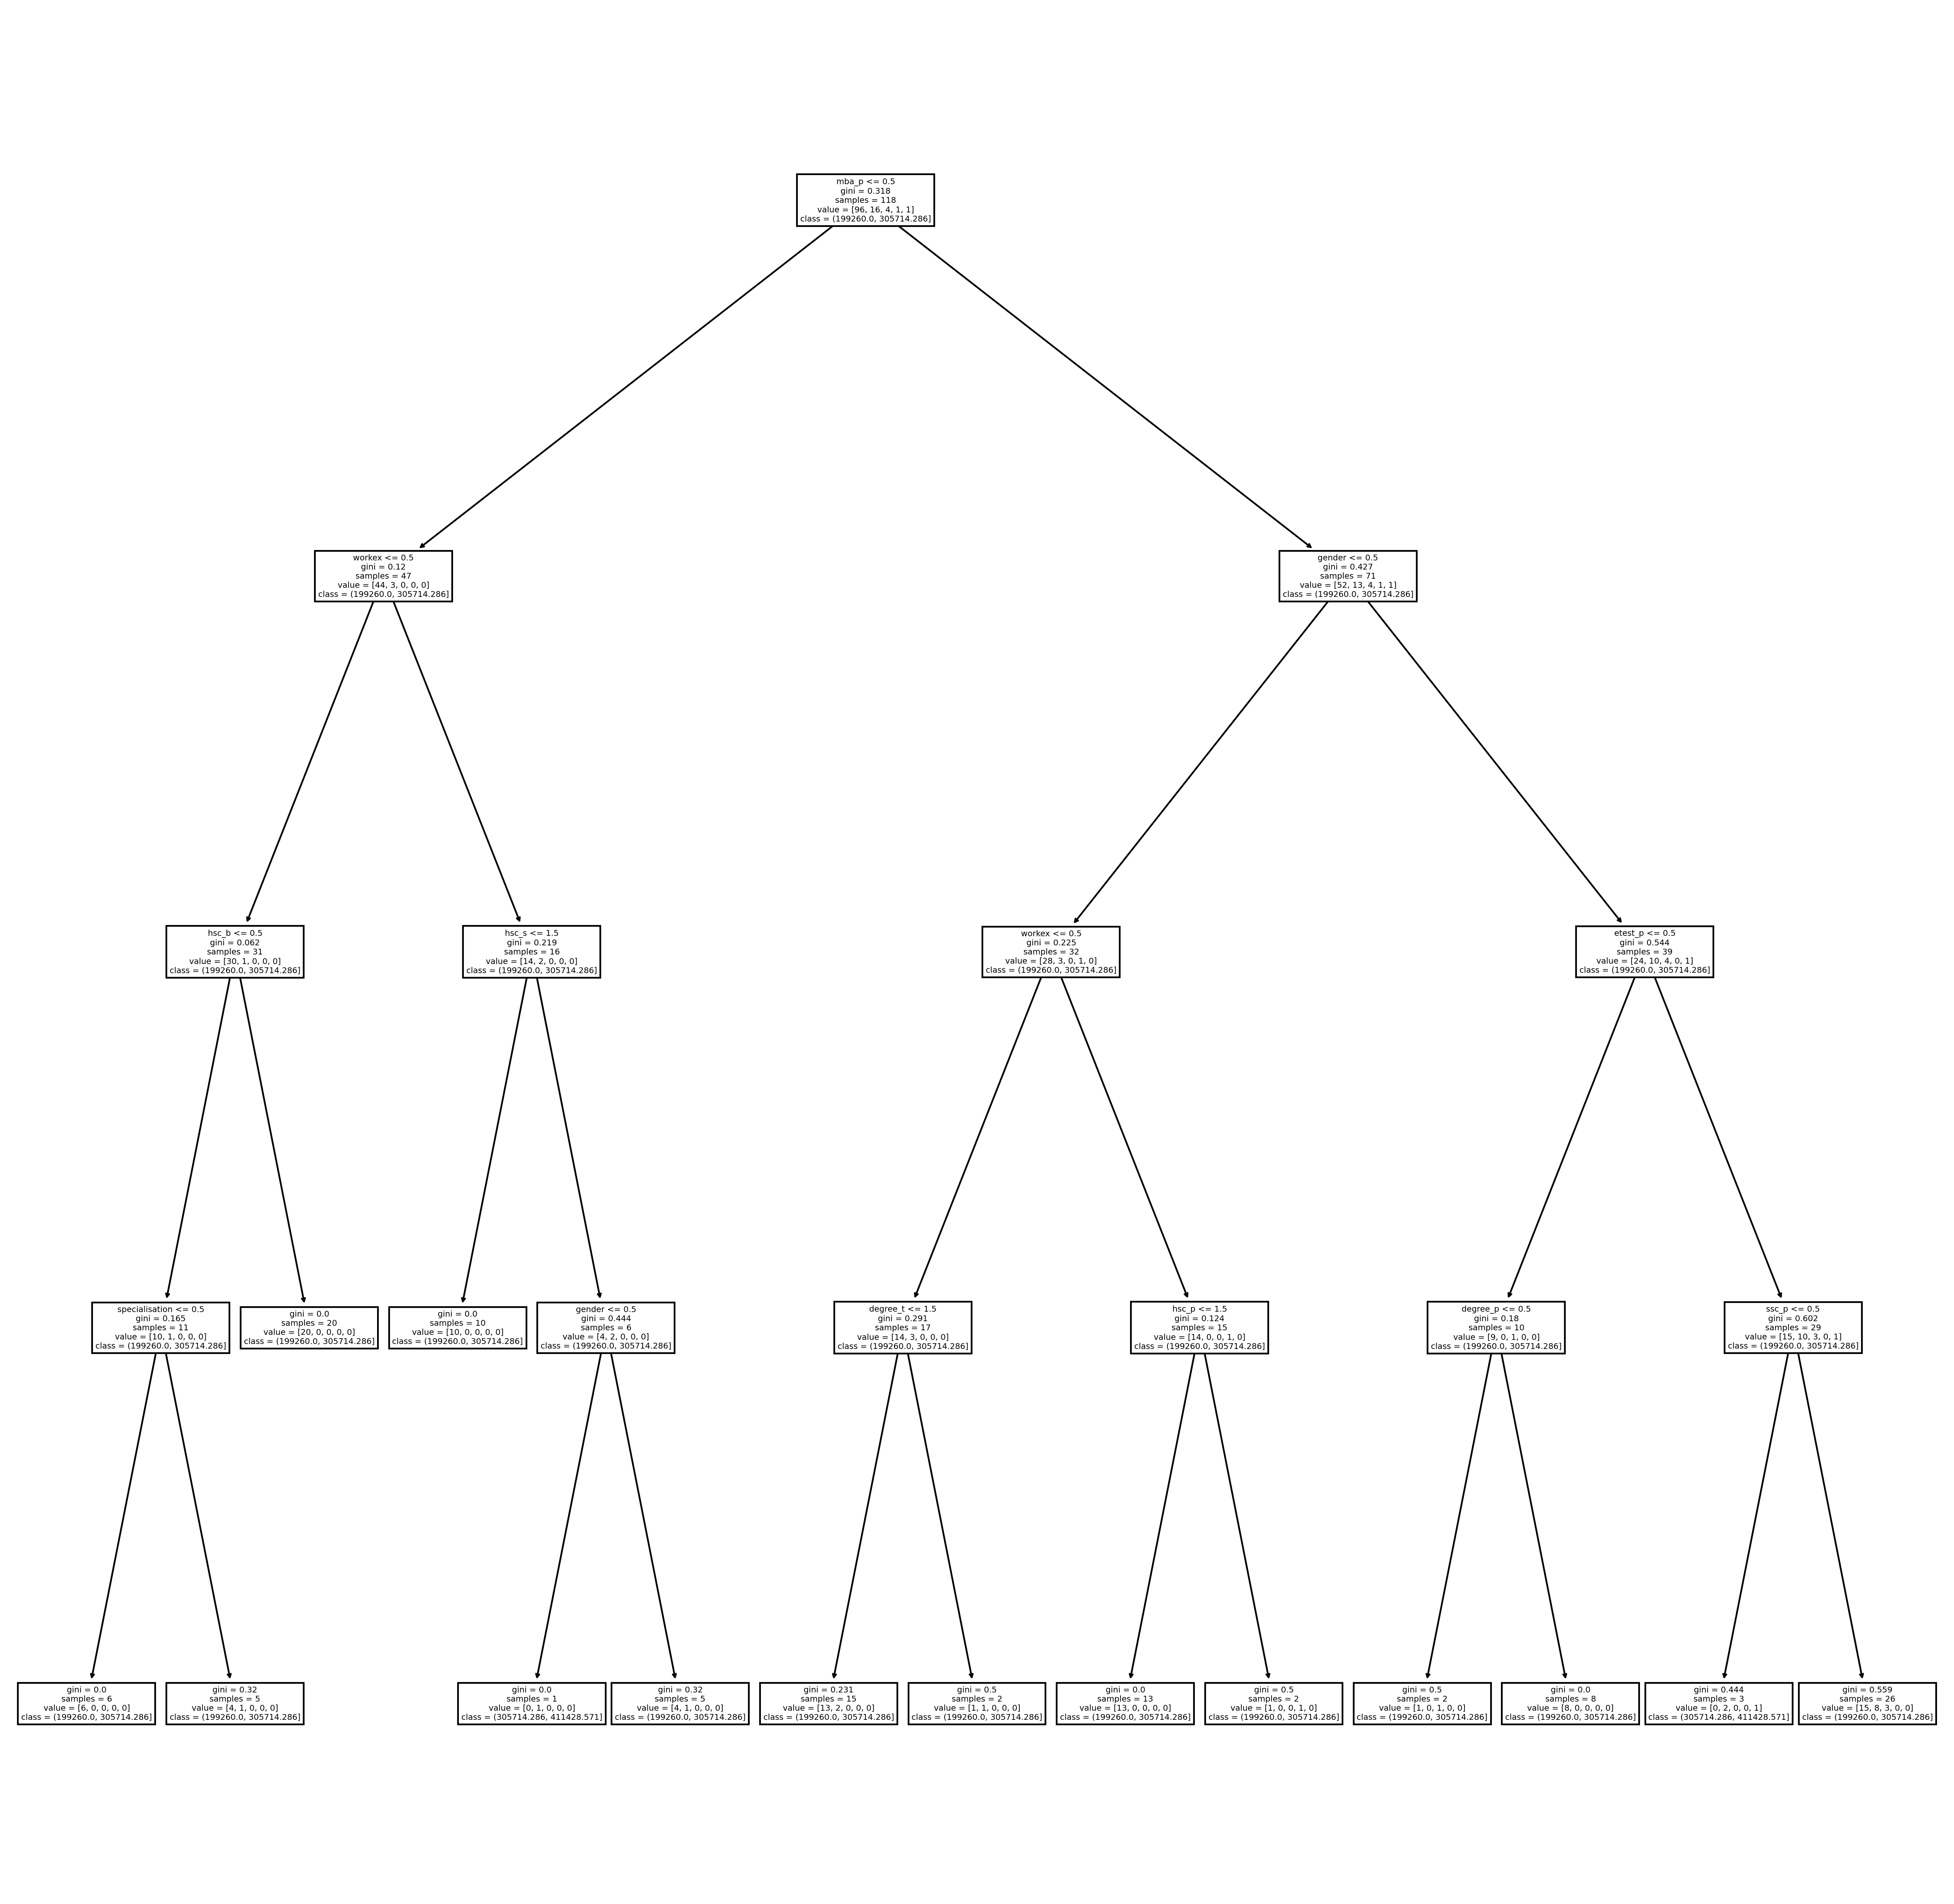

In [64]:
# Include decision tree visualization here
figure(figsize=(20,20), dpi=300)
tree.plot_tree(clf_depth, feature_names=feature_names, class_names=enc.categories_[-1])
plt.show()

# Discuss what the model has learned

The SciKit-Learn DecisionTreeClassifier has learned from my MBA dataset that most of these graduated students have salaries between ~$200,000 and ~$300,000 and predicts that class most of the time. This of course is affected greatly by how I have binned my continuous features in the dataset. However, having more bins leads to much lower accuracy. It turns out that making a prediction in this range almost all the time leads to the highest accuracy.

## 6. (optional 5% extra credit) Implement reduced error pruning to help avoid overfitting.  
- You will need to take a validation set out of your training data to do this, while still having a test set to test your final accuracy. 
- Create a table comparing your decision tree implementation's results on the cars and voting data sets with and without reduced error pruning. 
- This table should compare:
    - a) The # of nodes (including leaf nodes) and tree depth of the final decision trees 
    - b) The generalization (test set) accuracy. (For the unpruned 10-fold CV models, just use their average values in the table).